### Imports

In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from pathlib import Path
from glob import  glob
import seaborn as sns

import segmentation_models_pytorch as smp
import timm
import cv2 as cv2
import itertools
import math
import scipy

from scipy.stats import norm
from sklearn.neighbors import KernelDensity

/home/pedke/multi-task-learning/pedke-venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Functions

In [2]:
def get_extreme_value(tnsr, mode, index):
    tnsr_squeezed = torch.Tensor(tnsr).squeeze(1)
    
    if mode == 'max':
        val = torch.max(tnsr_squeezed, dim=0)[0][index]
    elif mode == 'min':
        val = torch.min(tnsr_squeezed, dim=0)[0][index]
        
    non_zero_vals = (tnsr_squeezed == val).nonzero()
    
    indices = [i[0].item() for i in non_zero_vals]
    
    return tnsr_squeezed[indices]
    

In [3]:
def max_distance(min_values, max_values):
    dist_sofar = 0
    for pair in list(itertools.product(min_values, max_values)):
        distance = math.dist(pair[0], pair[1])
        if distance > dist_sofar:
            dist_sofar = distance
        print(f"Distance between {pair}: {distance}")
    
    return dist_sofar

In [4]:
def compute_longest_dist(hull):
    count, dist_sofar = 0, 0

    for pair in list(itertools.product(hull.squeeze(1), hull.squeeze(1))):
        count +=1
        distance = math.dist(pair[0], pair[1])
        if distance > dist_sofar:
            dist_sofar = distance
            points = pair

    # print(count, dist_sofar, points)
    return dist_sofar, points

In [5]:
def rotated_bounding_box(mask_path, name, fname, save_dir):
    img = cv2.imread(mask_path) 

    # Convert to grayscale 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    
    #to separate the object from the background 
    ret, thresh = cv2.threshold(gray, 127, 255, 0) 
    
    # Dilating the mask
    # https://stackoverflow.com/questions/68984409/cant-find-right-numbers-of-contours-count
    kernel = np.ones((3, 3), dtype=np.uint8)
    thresh = cv2.dilate(thresh, kernel, iterations=2)
    
    # Find the contours of the object  
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
    
    # print(len(contours))
    contours = np.vstack(contours[i] for i in range(len(contours)) if cv2.contourArea(contours[i]) > 1000)
    # print(len(contours))
    
    # longest dist
    hull = cv2.convexHull(contours)
    uni_hull = [hull]
    cv2.drawContours(img,uni_hull,-1,(0,255,255),2)
    
    longest_dist, pnts = compute_longest_dist(hull)
    
    for val in list(pnts):
        x, y = np.array(val)
        # print(np.array(val), x, y )
        cv2.circle(img, (int(x), int(y)), radius=10, color=(255, 0, 0), thickness=-1)
        
    # --------------------------------------
    
    # rotated rect
    rect = cv2.minAreaRect(contours)
    r_h, r_w = rect[1]
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img,[box],0,(0,0,255),2)
    
    # rect
    x,y,w,h = cv2.boundingRect(contours)
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    
    # ellipse
    ellipse = cv2.fitEllipse(contours)
    e_h, e_w = ellipse[1]
    cv2.ellipse(img,ellipse,(255,255,0),2)
    
    if 'rethral' in fname:
        r_w = min(rect[1])
        w = min(w, h)
        e_w = min(ellipse[1])
    
    # pixel counting area
    gray[gray > 0] = 1
    # print(np.unique(gray), gray.shape)
    mask_area = torch.sum(torch.sum(torch.Tensor(gray), dim=-1), dim=-1).item()
    
    # contour area counting
    # assert len(contours) == 1
    contour_area = cv2.contourArea(contours[0])
    
    folder_save_path = f"{save_dir}{fname}/"
    Path(folder_save_path).mkdir(parents=True, exist_ok=True)
    cv2.imwrite(f'{folder_save_path}{name}.jpeg', img) 
    
    dists = [w, r_w, e_w, longest_dist]
    areas = [mask_area, contour_area]
    return hull, dists, areas, img
    
    

Generate stripplot

In [35]:
def generate_stripplot(x, y, df, limits=None, xlabel=None, ylabel=None, title=None):
    plot = sns.stripplot(data=df, x=x, y=y)
    
    if limits:
        plot.set_ylim(limits)

    sns.boxplot(showmeans=True,
                meanline=True,
                meanprops={'color': 'k', 'ls': '-', 'lw': 2},
                medianprops={'visible': False},
                whiskerprops={'visible': False},
                zorder=10,
                x=x,
                y=y,
                data=df,
                showfliers=False,
                showbox=False,
                showcaps=False,
                ax=plot).set(
    xlabel=xlabel, 
    ylabel=ylabel,
    title=title)
    plt.show()

In [24]:
def generate_plots(x, y, dataframes, xlabel=None, ylabel=None):
    for df in dataframes:
        generate_stripplot(x=x, y=y, df=df, xlabel=xlabel, ylabel=ylabel)

In [45]:
def fit_gaussian_curves(values, num_bins=25, curve=True, density=False, title=None):
    # Plot the histogram. 
    
    plt.hist(values, bins=num_bins, density=density, alpha=0.6, color='b', edgecolor="black") 
    
    if curve:
        # Fit a normal distribution to 
        # the data: 
        # mean and standard deviation 
        mu, std = scipy.stats.norm.fit(values)  
        
        # Plot the PDF. 
        xmin, xmax = plt.xlim() 
        x = np.linspace(xmin, xmax, 100) 
        p = scipy.stats.norm.pdf(x, mu, std) 
        
        plt.plot(x, p, 'k', linewidth=2) 
        title = "Fit Values: {:.2f} and {:.2f}".format(mu, std) 
        plt.title(title) 
    
    plt.xlabel("Ratio values")
    plt.ylabel("Frequency")
    plt.title(title)
    
    plt.show() 

### Testing an example

In [9]:
img_name = "_1140382.JPG"
img_path = "/home/pedke/dataset/datasets/15-October-23_split - no_special_chars/train/images/_1140382.JPG"
gmask_path = "/home/pedke/dataset/datasets/15-October-23_split - no_special_chars/train/masks/_1140382_glans.JPG" 
smask_path = "/home/pedke/dataset/datasets/15-October-23_split - no_special_chars/train/masks/_1140382_penileshaft.JPG"
umask_path = "/home/pedke/dataset/datasets/15-October-23_split - no_special_chars/train/masks/_1140382_urethralplate.JPG"

img = np.asarray(ImageOps.exif_transpose(Image.open(img_path)).convert("RGB"))
gmask = torch.Tensor(np.array(ImageOps.exif_transpose(Image.open(gmask_path)).convert("L")))
smask = torch.Tensor(np.array(ImageOps.exif_transpose(Image.open(smask_path)).convert("L")))
umask = torch.Tensor(np.array(ImageOps.exif_transpose(Image.open(umask_path)).convert("L")))

gmask[gmask > 0] = 1
smask[smask > 0] = 1
umask[umask > 0] = 1

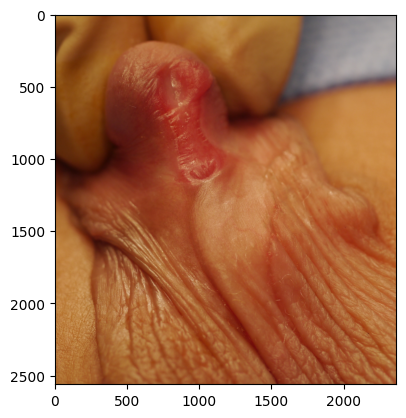

In [10]:
plt.imshow(img)

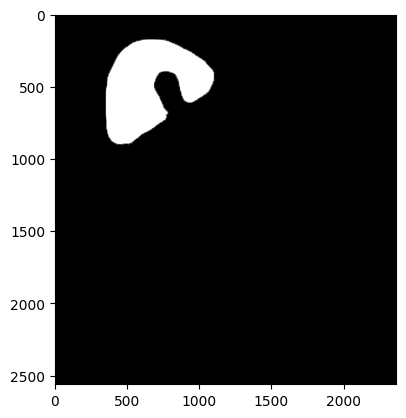

In [10]:
plt.imshow(gmask, cmap='gray')

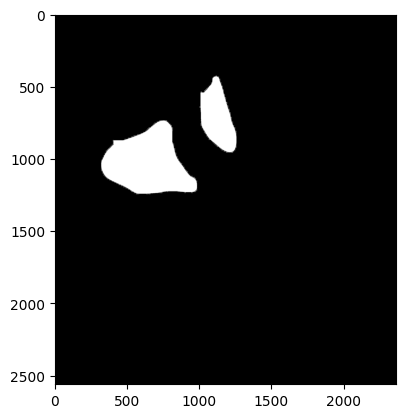

In [15]:
plt.imshow(smask, cmap='gray')

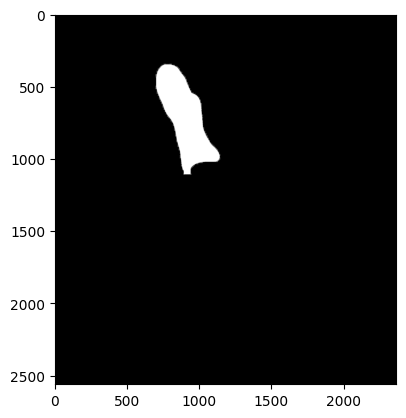

In [11]:
plt.imshow(umask, cmap='gray')

In [12]:
gvol = torch.sum(torch.sum(gmask, dim=-1), dim=-1)
svol = torch.sum(torch.sum(smask, dim=-1), dim=-1)
uvol = torch.sum(torch.sum(umask, dim=-1), dim=-1)
gvol, svol, uvol, gvol/svol, uvol/svol

(tensor(323579.),
 tensor(296106.),
 tensor(158698.),
 tensor(1.0928),
 tensor(0.5359))

In [13]:
# g_hull, g_min_values, g_max_values = rotated_bounding_box(gmask_path, 'Glans')
# s_hull, s_min_values, s_max_values = rotated_bounding_box(smask_path, 'Shaft')
# hull, dists, areas, img

g_hull, g_longest_dist, g_area, g_img = rotated_bounding_box(gmask_path, 'Glans', img_name, "/home/pedke/multi-task-learning/ratios/")
s_hull, s_longest_dist, s_area, s_img = rotated_bounding_box(smask_path, 'Shaft', img_name, "/home/pedke/multi-task-learning/ratios/")
u_hull, u_longest_dist, u_area, u_img = rotated_bounding_box(umask_path, 'UP', img_name, "/home/pedke/multi-task-learning/ratios/")

/tmp/ipykernel_1627933/3885617743.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  contours = np.vstack(contours[i] for i in range(len(contours)) if cv2.contourArea(contours[i]) > 1500)
/tmp/ipykernel_1627933/3885617743.py:40: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


In [22]:
g_longest_dist, s_longest_dist

([752, 855.4405517578125, 877.9855346679688, 855.4788132969746],
 [940, 1032.9710693359375, 1040.46875, 1043.7633831477324])

In [15]:
g_area, s_area, u_area, g_area[0] == gvol, s_area[0] == svol, u_area[0] == uvol

([323579.0, 0.0],
 [296106.0, 0.0],
 [158698.0, 0.0],
 tensor(True),
 tensor(True),
 tensor(True))

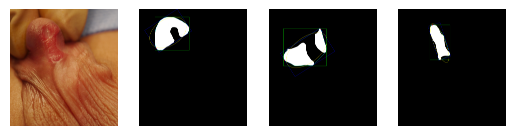

In [16]:
# img = cv2.imread(img_path) 
f, axarr = plt.subplots(1,4)
axarr[0].imshow(img)
axarr[0].axis('off')

axarr[1].imshow(g_img)
axarr[1].axis('off')

axarr[2].imshow(s_img)
axarr[2].axis('off')

axarr[3].imshow(u_img)
axarr[3].axis('off')

f.savefig(f'/home/pedke/multi-task-learning/ratios/{img_name}/full_figure.png')


### Code to compute ratios

Setting image paths

In [9]:
image_dir = "/home/pedke/dataset/datasets/15-October-23_split - no_special_chars/train/images/"
mask_dir = "/home/pedke/dataset/datasets/15-October-23_split - no_special_chars/train/masks/"
output_dir = "/home/pedke/multi-task-learning/ratios/output/"

In [10]:
Path(output_dir).mkdir(parents=True, exist_ok=True)

Reading in labels

In [11]:
score_df = pd.read_excel("/home/pedke/dataset/datasheets/FINAL Copy of Classification - no_special_chars.xlsx",skiprows=1)
score_df.rename(columns={score_df.columns[0]: "Image Name"}, inplace=True)
score_df.drop(score_df.columns[[1, 18]], axis=1, inplace=True)

In [12]:
labels_dict = {}
for path in Path(image_dir).glob("*"): 
    score_name = path.stem
    
    labels = []
    for bodypart in ['Glans', 'Meatus', 'Urethral Plate']:
        s = score_df.stack().str.contains(score_name, na=False)
        img_row = score_df.iloc[[s[s].index[0][0]]]

        score = img_row[f'{bodypart} Concensus'].item()
        if pd.isna(score):
            score = img_row[f'{bodypart} 1'].item()

        score = int(score)
        # img_label = score - 1
        img_label = score

        labels.append(img_label)
    
    labels_dict[score_name] = labels

labels_df = pd.DataFrame.from_dict(labels_dict, orient='index', columns=['G-Label', 'M-Label', 'UP-Label'])
labels_df

G-Label  M-Label  UP-Label
1.0 Hipospadia peniana distal com chordee e cap...        3        3         3
2015-03-25 10.58.24                                       3        4         3
2017-07-20, 07 40 08                                      1        1         2
2018-01-15 11.56.02                                       2        3         2
2018-03-22 07.44.35                                       2        2         1
...                                                     ...      ...       ...
bad plate                                                 2        2         4
c3                                                        3        1         1
camara abril 2 de 2013 003                                2        2         2
camara dic 10 de 2013 018                                 2        2         2
preop- severe chordee                                     2        4         3

[155 rows x 3 columns]

Generating ratios

1.0 Hipospadia peniana distal com chordee e caput dorsal


/tmp/ipykernel_1851422/4001473736.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  contours = np.vstack(contours[i] for i in range(len(contours)) if cv2.contourArea(contours[i]) > 1000)
/tmp/ipykernel_1851422/4001473736.py:40: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


2015-03-25 10.58.24
2017-07-20, 07 40 08
2018-01-15 11.56.02
2018-03-22 07.44.35
2018-03-27 07.41.06
2018-04-03 10.55.47
2018-04-03 10.55.58
2018-04-03 10.56.25
2018-04-11 07.39.23
2018-04-12 12.19.40
2018-04-16 07.50.26
2018-04-19 13.48.18
2018-05-29 07.45.20
2018-05-29 07.46.01
2018-06-14 07.36.09
5.0 Hipospadia peniana proximal, uretra hipoplasica, caput do
Camara agosto 12 de 2013 023
Camara agosto 25 de 2011 025
Camara agosto 25 de 2011 040
Camara agosto 25 de 2011 041
Camara febrero 26 de 2013 090


/tmp/ipykernel_1851422/2739321414.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, axarr = plt.subplots(1,num_plots)


Camara julio 30 de 2014 005
DSC00093
DSC00094
DSC00132
DSC00191
DSC00193
DSC00378
DSC00400
DSC00409
DSC00481
DSC00482
DSC00515
DSC00534
DSC00536
DSC00724
DSC00960
DSC00990
DSC00992
DSC00993
DSC00997
DSC01097
DSC01098
DSC01113
DSC01230
DSC01262
DSC01816
DSC01854
DSC01856
DSC01893
DSC01897
DSC02082
DSC02083
DSC02089
DSC02093
DSC02150
DSC02504
DSC02506
DSC02508
DSC02828
DSC02946
DSC02947
DSC03036
DSC03110
DSC03130
DSC03187
DSC04151
DSC05559
DSC05986
DSC06760
DSC07270
DSC07275
DSC07545
DSC07669
DSC07865
DSC07866
DSC07892
DSC07979
DSC08110
DSC08341
DSC08643
DSC08984
DSC09326
DSC09556
DSCF0172
DSCF1855
DSCF3148
DSCF3536
DSCF5003
DSCF5289
DSCF5381
DSCF5589
DSCF6559
DSCF6928
DSCF8221
DSCN2240
DSCN2289
DSCN2460
DSC_0066
DSC_0071
Good plate adolescent
Good plate!
Hipospadia HCC 003
IMG_0661
IMG_1228
IMG_4332
IMG_4375
IMG_4686
IMG_5412
IMG_5530
IMG_8666
IMG_9995
Iphone marzo 1 de 2012 043
Mild hypo
P1010437
P1010674
P1010675
P1040428
P1050005
P1080125
P1080129
P1090589
Photo 2014-07-14, 8 35 04 A

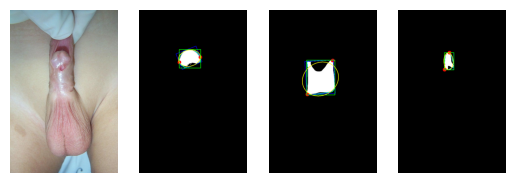

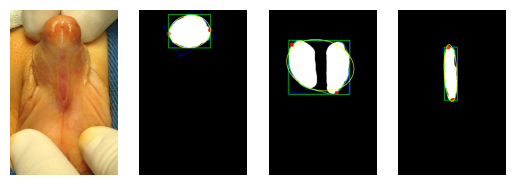

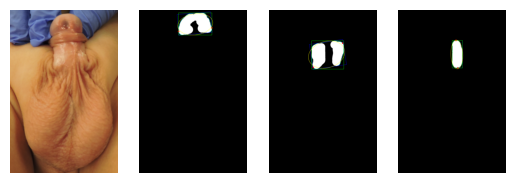

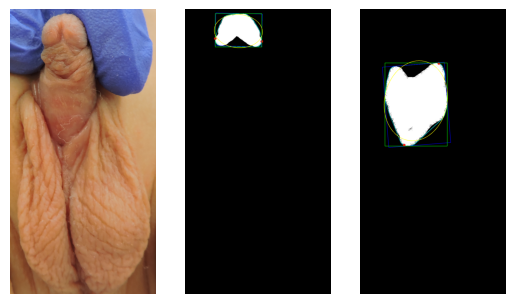

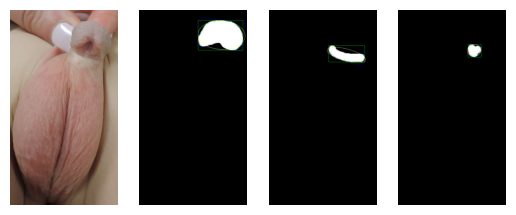

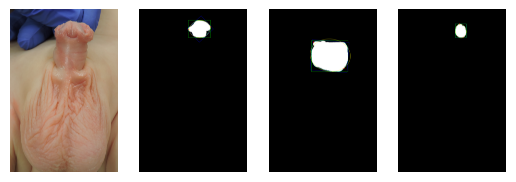

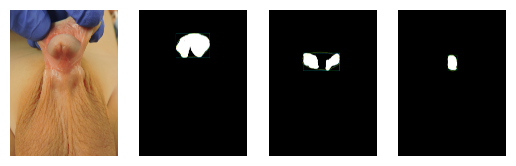

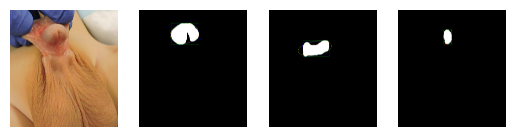

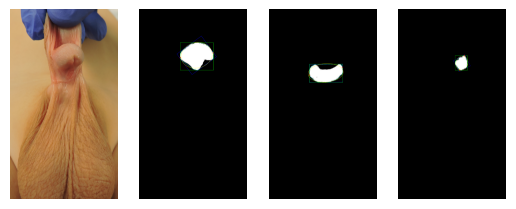

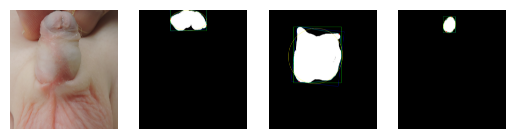

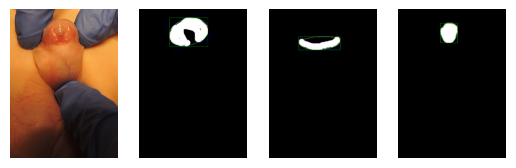

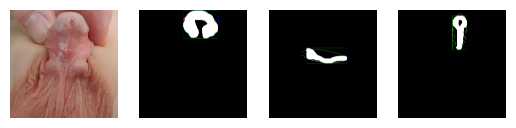

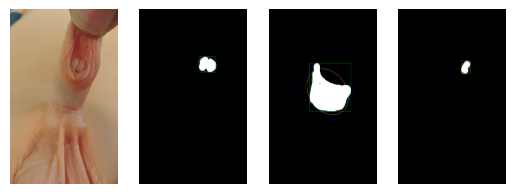

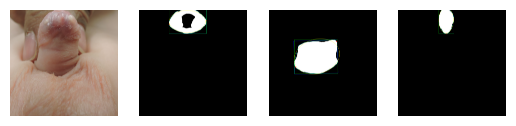

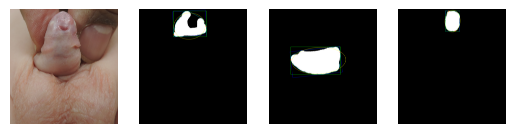

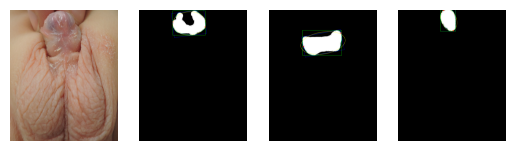

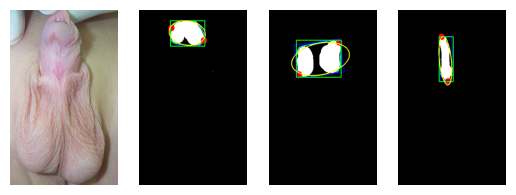

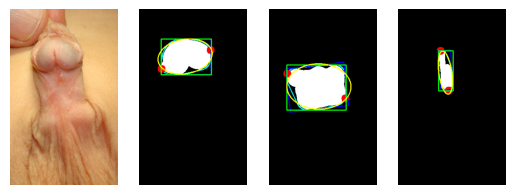

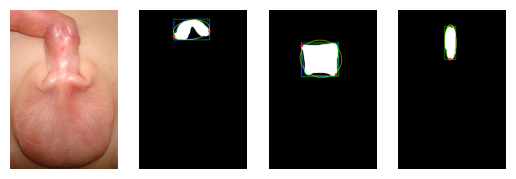

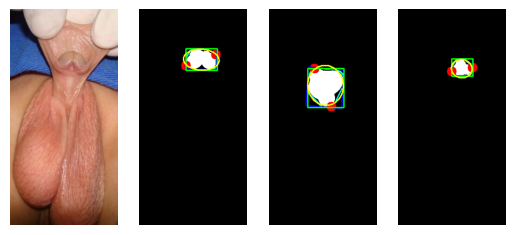

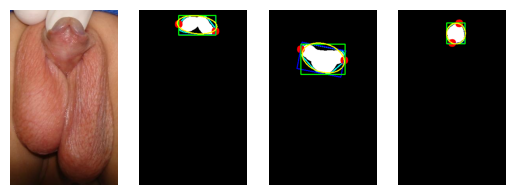

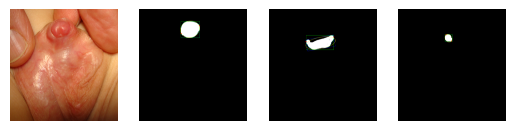

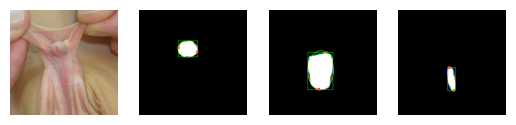

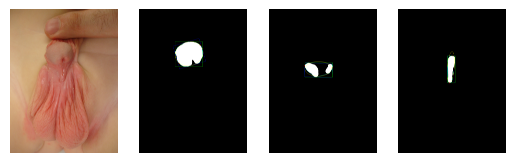

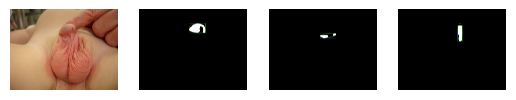

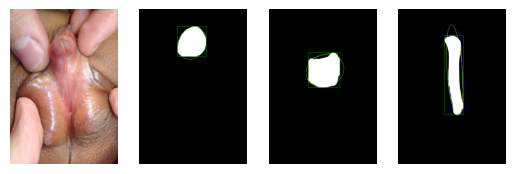

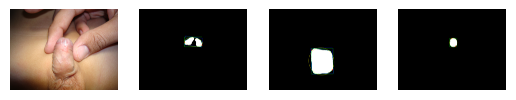

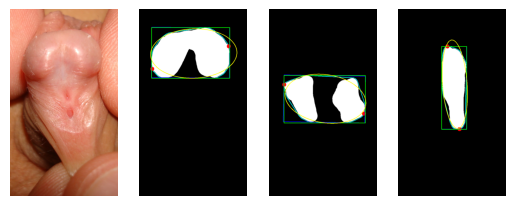

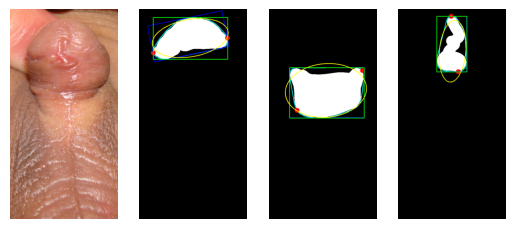

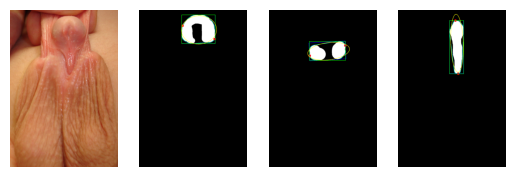

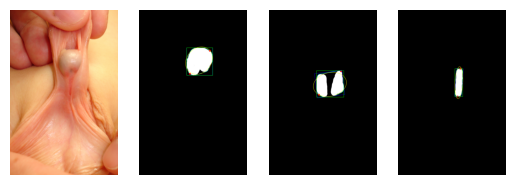

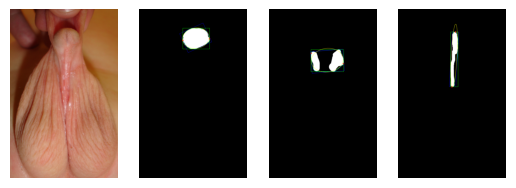

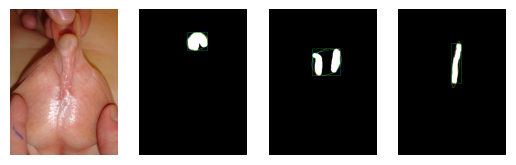

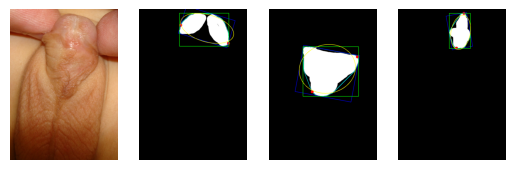

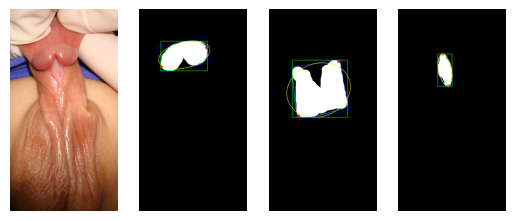

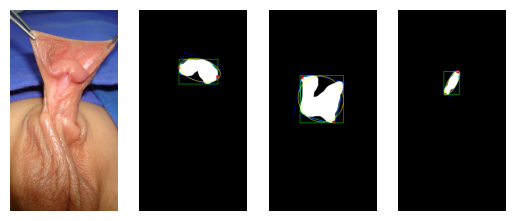

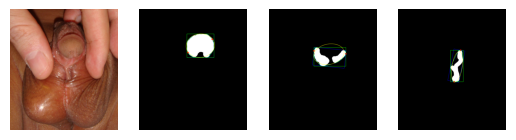

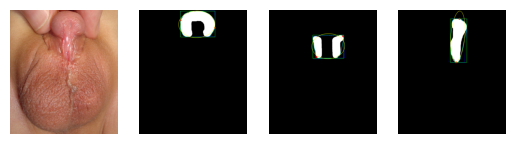

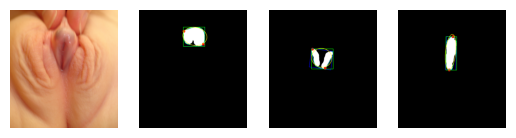

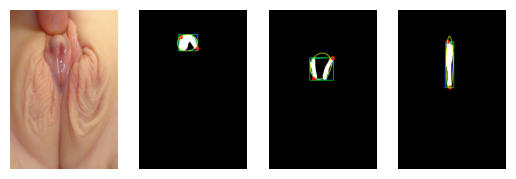

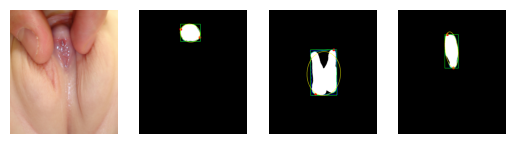

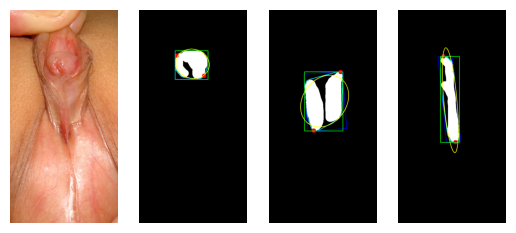

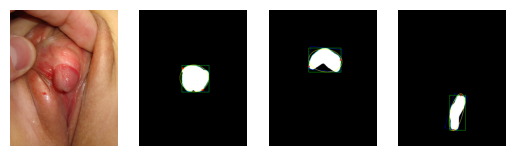

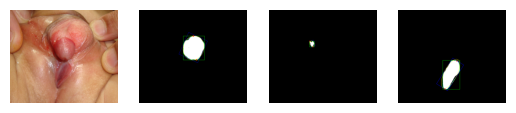

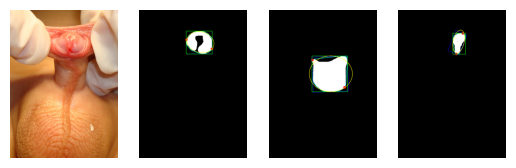

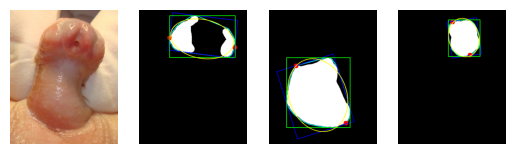

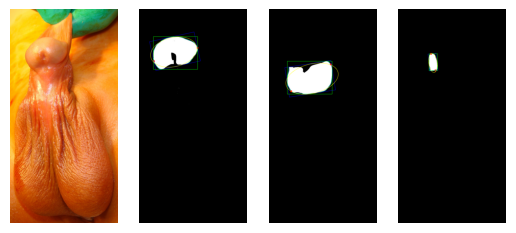

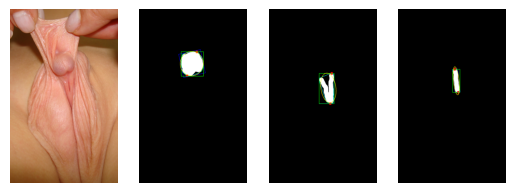

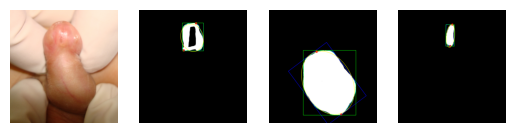

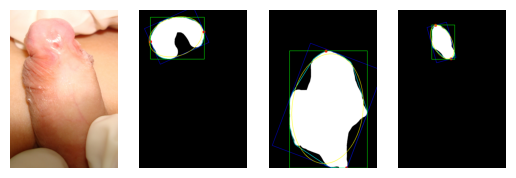

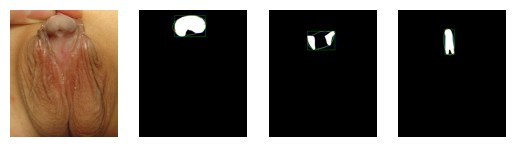

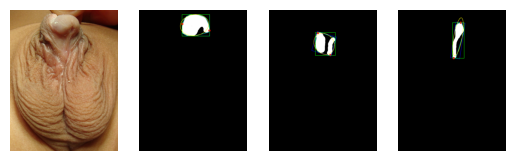

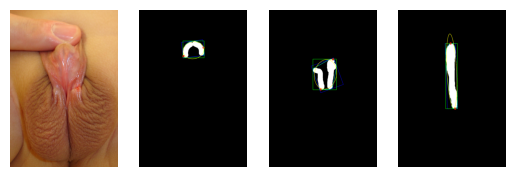

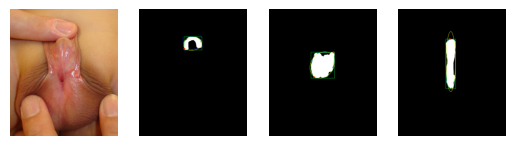

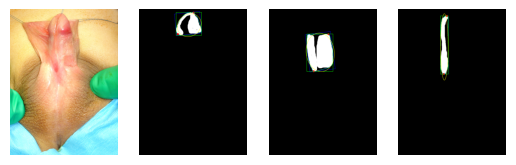

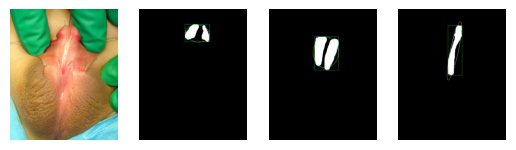

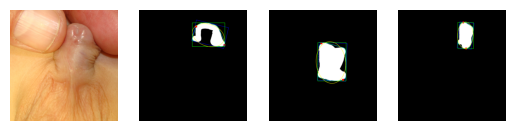

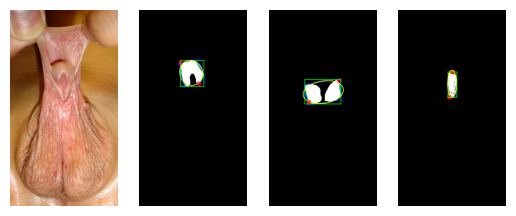

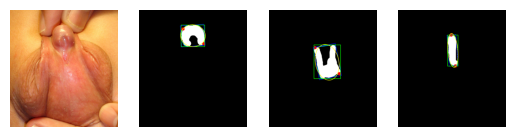

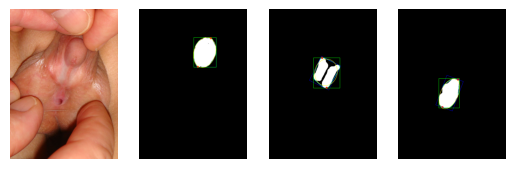

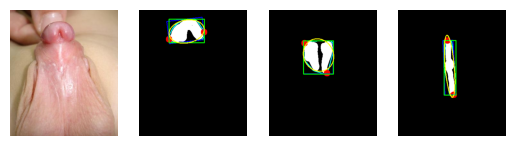

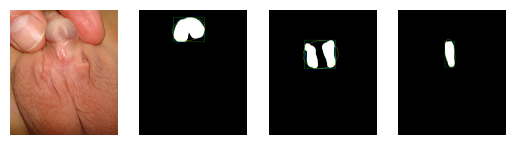

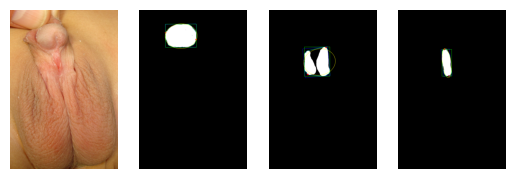

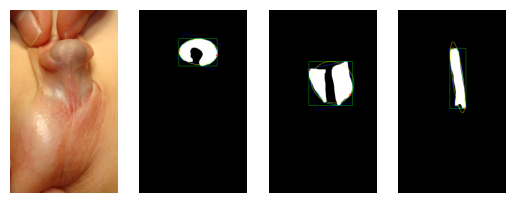

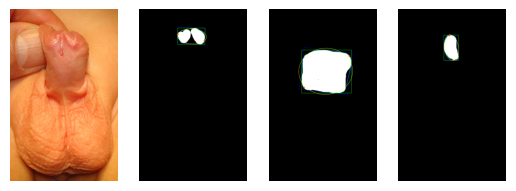

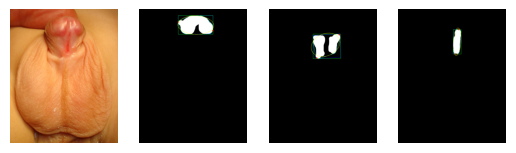

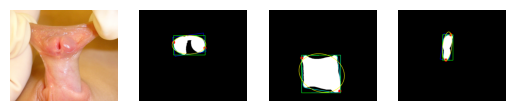

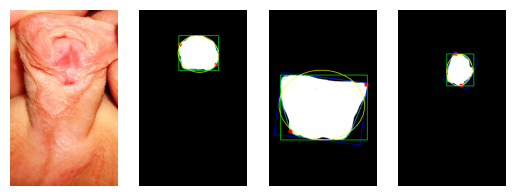

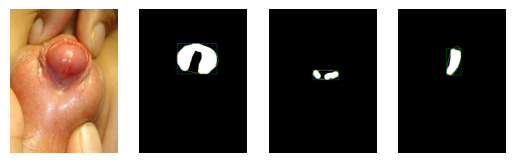

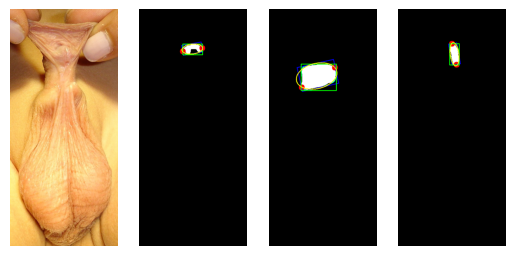

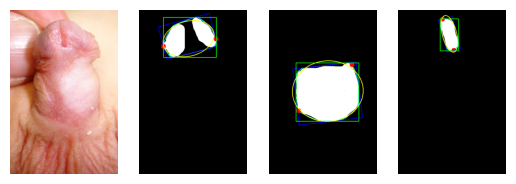

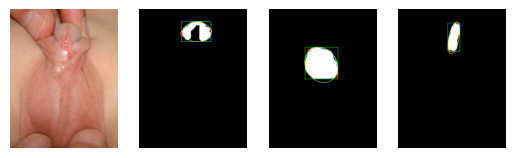

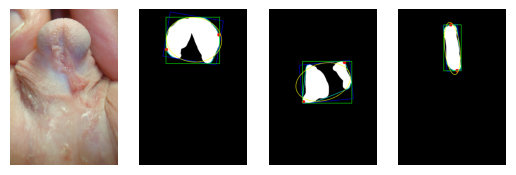

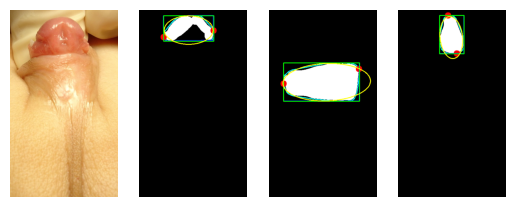

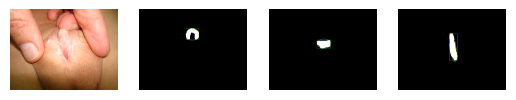

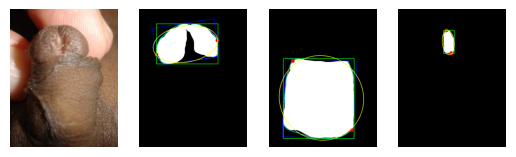

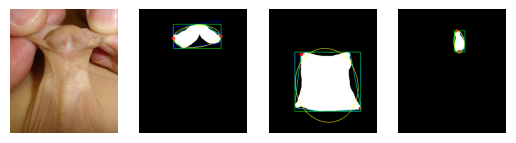

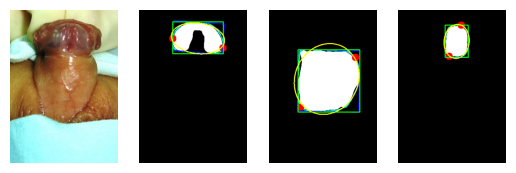

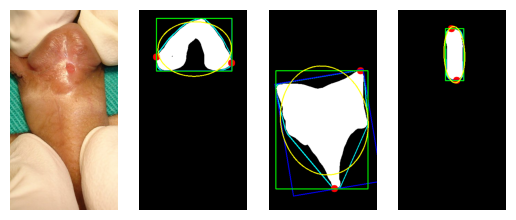

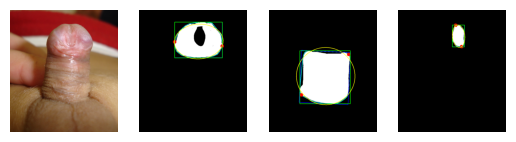

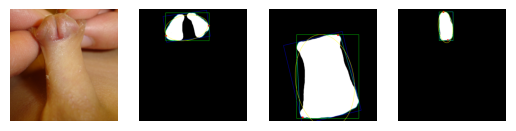

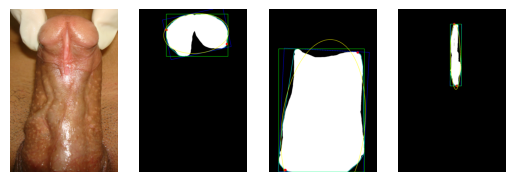

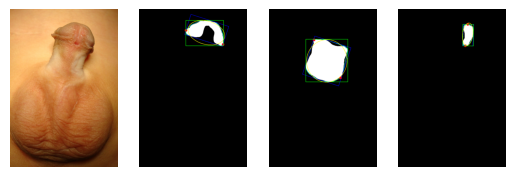

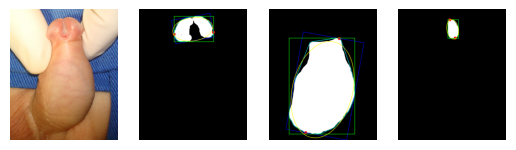

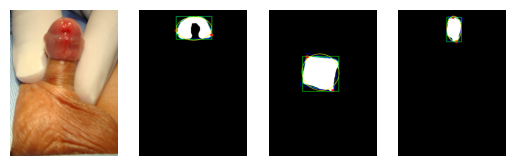

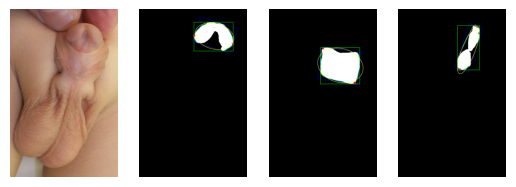

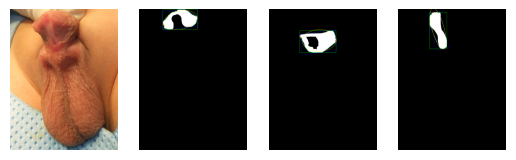

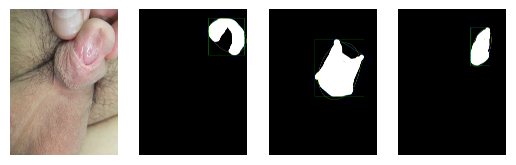

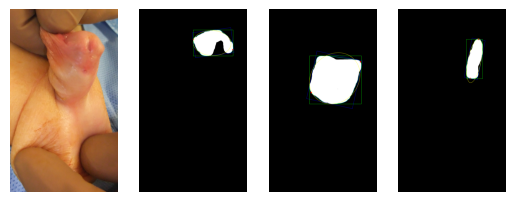

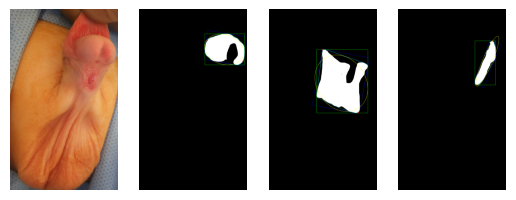

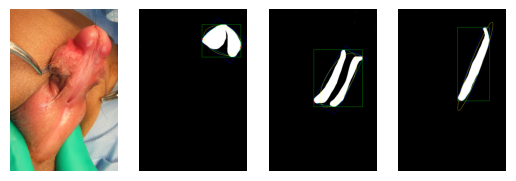

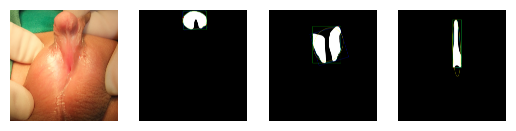

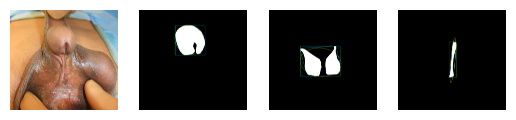

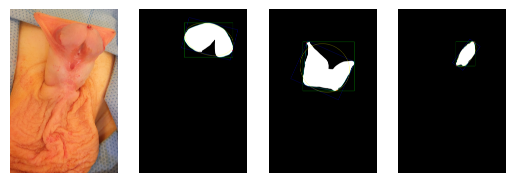

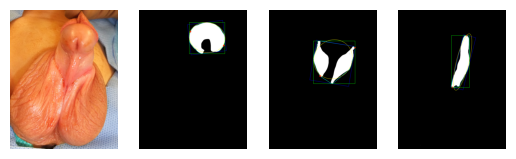

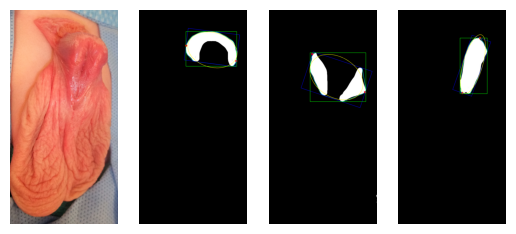

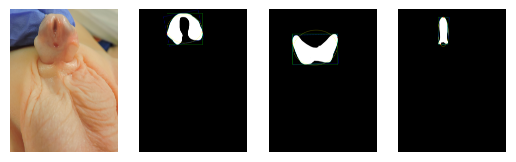

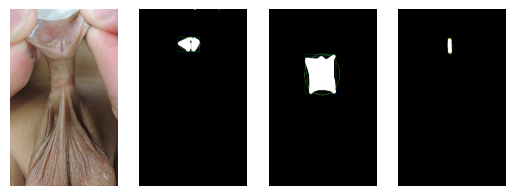

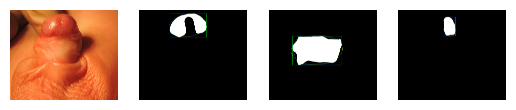

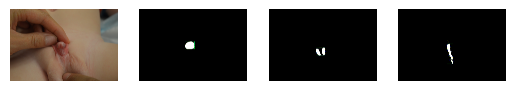

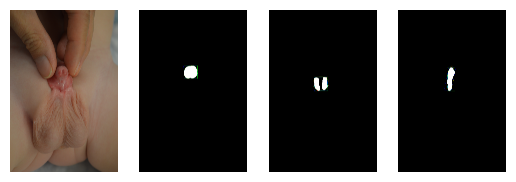

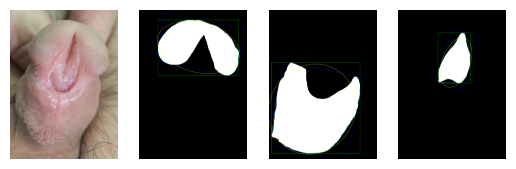

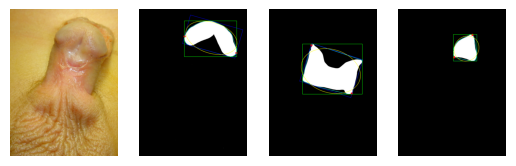

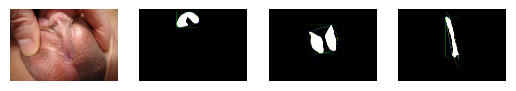

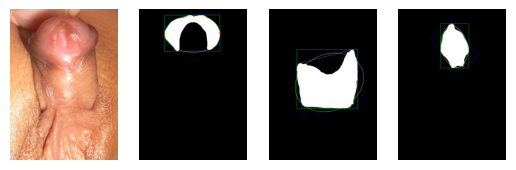

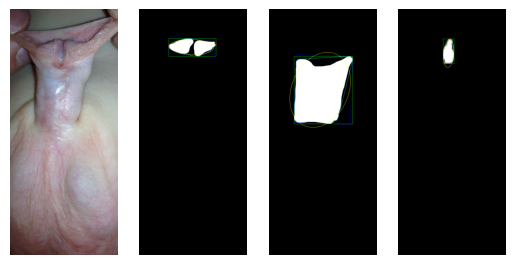

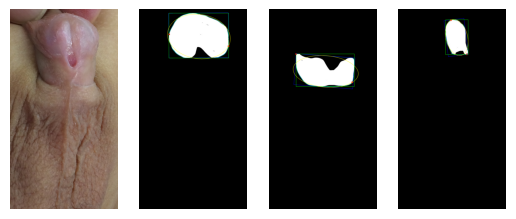

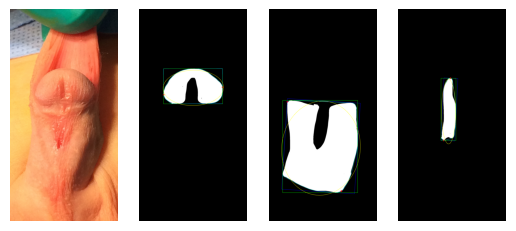

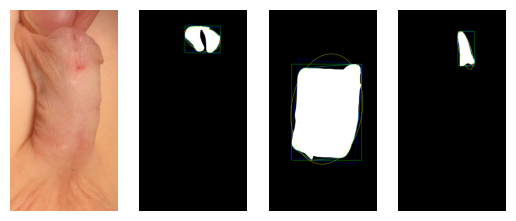

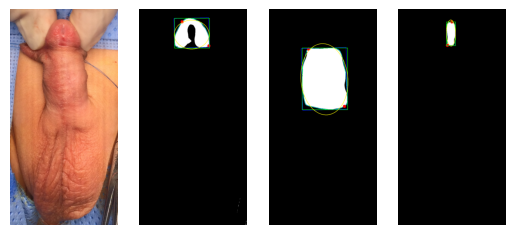

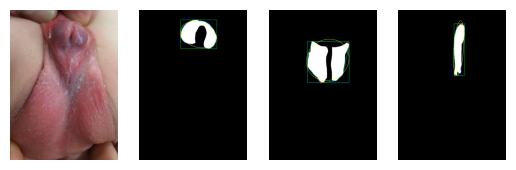

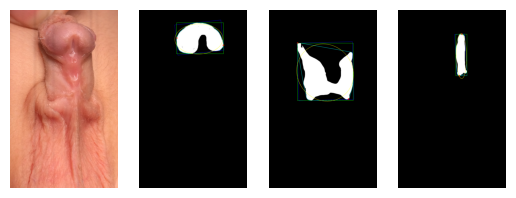

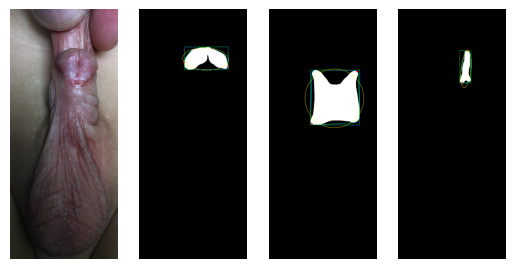

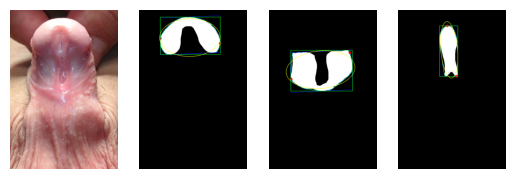

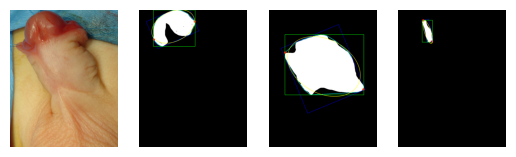

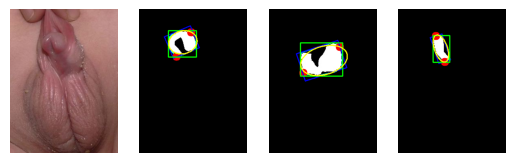

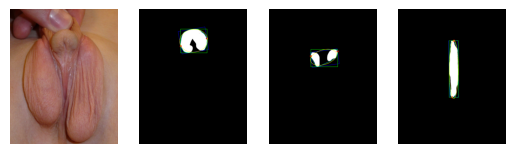

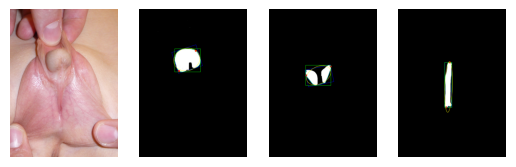

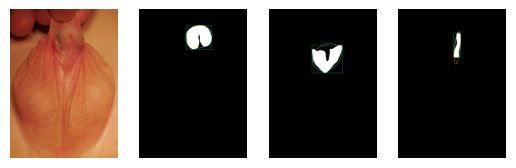

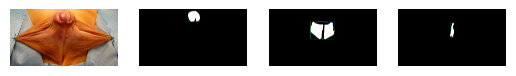

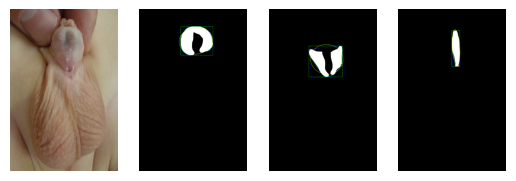

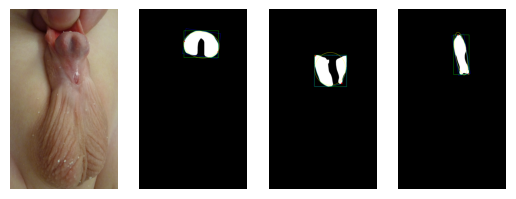

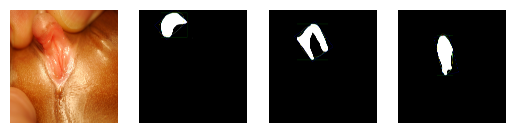

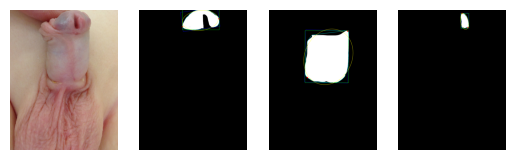

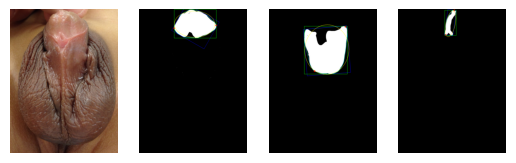

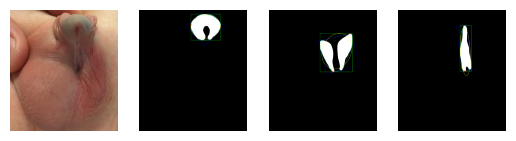

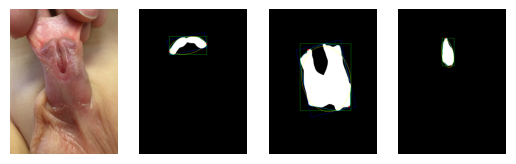

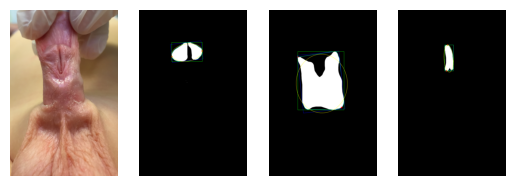

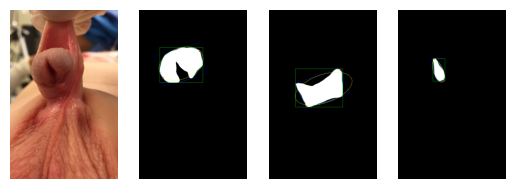

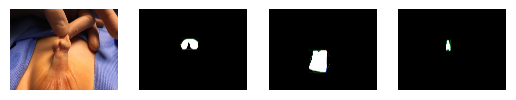

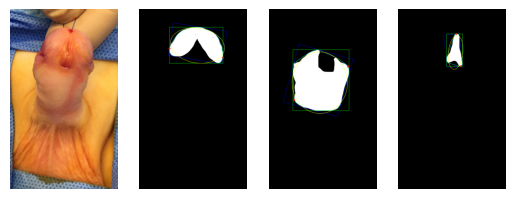

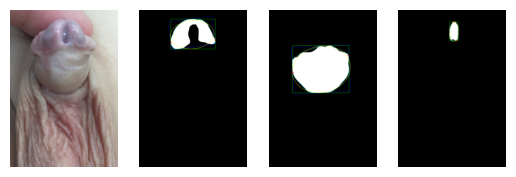

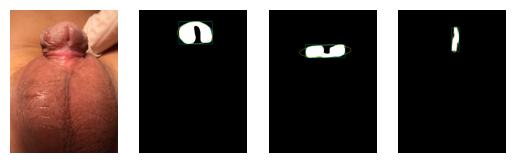

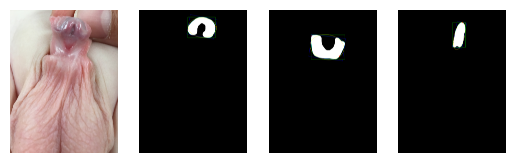

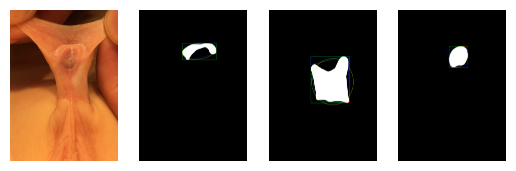

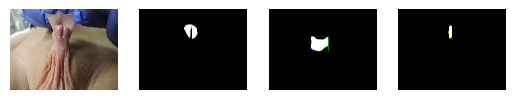

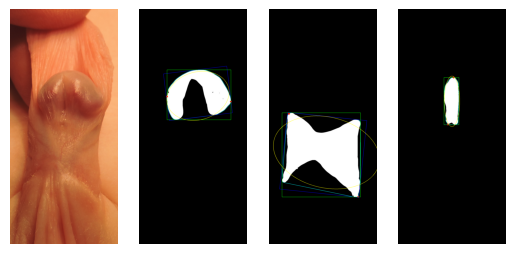

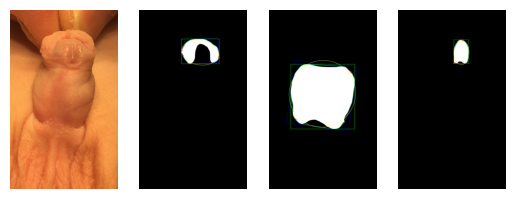

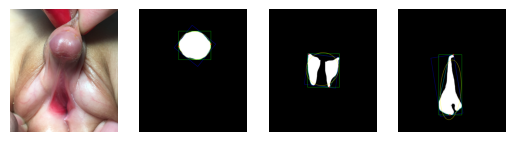

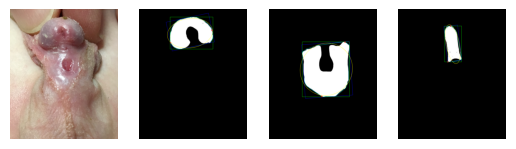

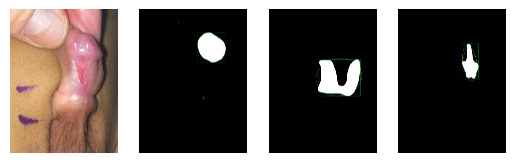

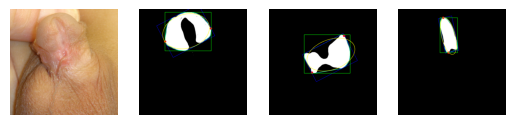

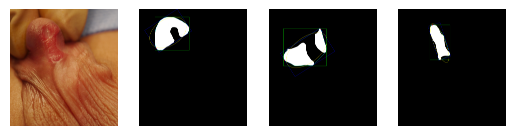

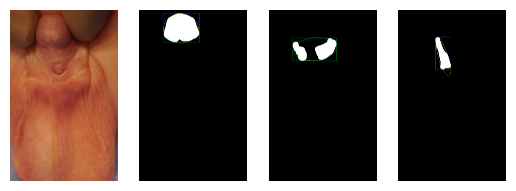

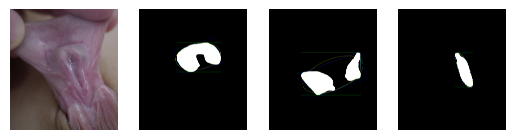

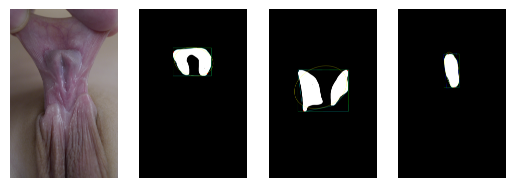

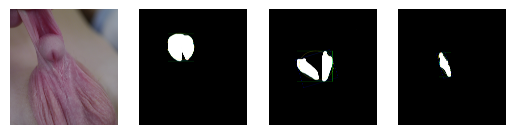

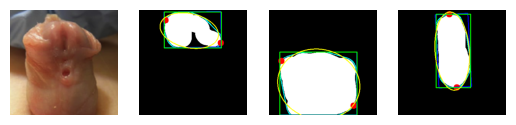

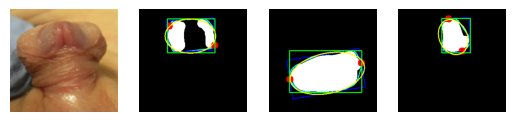

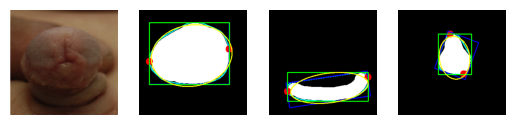

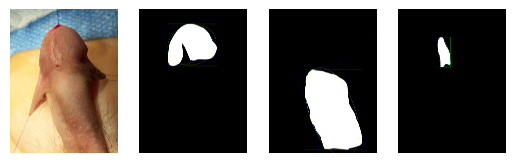

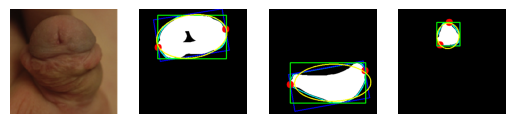

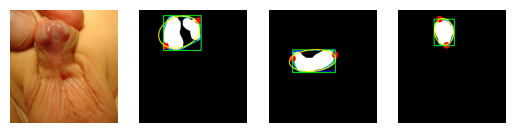

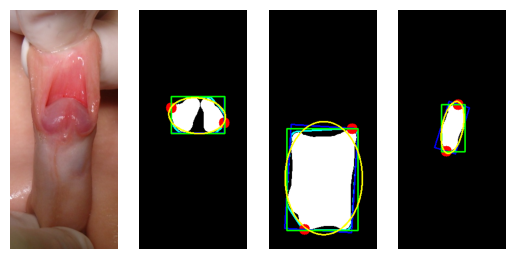

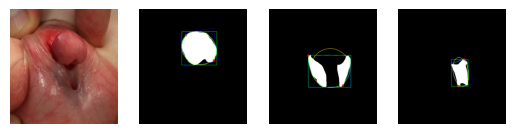

In [13]:
g_dist_dicts = {}
s_dist_dicts = {}
g_dist_s_dist_ratio_dict = {}
g_area_s_dist_ratio_dict = {}
g_dist_s_area_ratio_dict = {}
g_area_s_area_ratio_dict = {}

u_dist_s_dist_ratio_dict = {}
u_dist_g_dist_ratio_dict = {}
no_up = []
# g_carea_s_dist_ratio_dict = {}
# g_dist_s_carea_ratio_dict = {}
# g_carea_s_carea_ratio_dict = {}

for path in Path(image_dir).glob("*"): 
    print(path.stem)
    g_mask_path = [n for n in glob(f'{mask_dir}{path.stem}*{("Glans").lower()}.*')][0]
    s_mask_path = [n for n in glob(f'{mask_dir}{path.stem}*{("Shaft").lower()}.*')][0]
    
    # print(g_mask_path)
    # print(s_mask_path)
    
    g_hull, g_longest_dists, g_areas, g_img = rotated_bounding_box(g_mask_path, 'Glans', path.stem, output_dir)
    s_hull, s_longest_dists, s_areas, s_img = rotated_bounding_box(s_mask_path, 'Shaft', path.stem, output_dir)
    
    
    g_dist_s_dist_ratios = (torch.Tensor(g_longest_dists)/torch.Tensor(s_longest_dists)).tolist()
    g_area_s_dist_ratios = (torch.full(torch.Tensor(s_longest_dists).shape, g_areas[0])/torch.Tensor(s_longest_dists)).tolist()
    g_dist_s_area_ratios = (torch.Tensor(g_longest_dists)/torch.full(torch.Tensor(g_longest_dists).shape, s_areas[0])).tolist()
    g_area_s_area_ratios = [g_areas[0]/s_areas[0]]
    
    
    # g_carea_s_dist_ratios = (torch.full(torch.Tensor(s_longest_dist).shape, g_areas[1])/torch.Tensor(s_longest_dists)).tolist()
    # g_dist_s_carea_ratios = (torch.Tensor(g_longest_dists)/torch.full(torch.Tensor(g_longest_dist).shape, s_areas[1])).tolist()
    # g_carea_s_carea_ratios = [g_areas[1]/s_areas[1]]
    
    g_dist_dicts[path.stem] = g_longest_dists
    s_dist_dicts[path.stem] = s_longest_dists
    g_dist_s_dist_ratio_dict[path.stem] = g_dist_s_dist_ratios
    g_area_s_dist_ratio_dict[path.stem] = g_area_s_dist_ratios
    g_dist_s_area_ratio_dict[path.stem] = g_dist_s_area_ratios
    g_area_s_area_ratio_dict[path.stem] = g_area_s_area_ratios
    
    
    # g_carea_s_dist_ratio_dict[path.stem] = g_carea_s_dist_ratios
    # g_dist_s_carea_ratio_dict[path.stem] = g_dist_s_carea_ratios
    # g_carea_s_carea_ratio_dict[path.stem] = g_carea_s_carea_ratios
    
    u_mask_path = [n for n in glob(f'{mask_dir}{path.stem}*{("plate").lower()}.*')]
    if len(u_mask_path) == 1:
        num_plots = 4
        u_mask_path = u_mask_path[0]
        u_hull, u_longest_dists, u_areas, u_img = rotated_bounding_box(u_mask_path, 'Urethral', path.stem, output_dir)
        
        u_dist_s_dist_ratios = (torch.Tensor(u_longest_dists)/torch.Tensor(s_longest_dists)).tolist()
        u_dist_g_dist_ratios = (torch.Tensor(u_longest_dists)/torch.Tensor(g_longest_dists)).tolist()
        
        u_dist_s_dist_ratio_dict[path.stem] = u_dist_s_dist_ratios
        u_dist_g_dist_ratio_dict[path.stem] = u_dist_g_dist_ratios
    
    else:
        num_plots = 3
        no_up.append(path.stem)
    
    
    img = np.asarray(ImageOps.exif_transpose(Image.open(path)).convert("RGB"))
    
    f, axarr = plt.subplots(1,num_plots)
    axarr[0].imshow(img)
    axarr[0].axis('off')

    axarr[1].imshow(g_img)
    axarr[1].axis('off')

    axarr[2].imshow(s_img)
    axarr[2].axis('off')
    
    if num_plots == 4:
        axarr[3].imshow(u_img)
        axarr[3].axis('off')

    # f.savefig(f'{output_dir}{path.stem}/full_figure.png')

Creating dataframes of different ratios

In [14]:
g_dist_s_dist_ratios_df = pd.DataFrame.from_dict(g_dist_s_dist_ratio_dict, orient='index', columns=['Rect', 'Rotated rect', 'Ellipse', 'Longest line'])
g_area_s_dist_ratios_df = pd.DataFrame.from_dict(g_area_s_dist_ratio_dict, orient='index', columns=['Rect', 'Rotated rect', 'Ellipse', 'Longest line'])
g_dist_s_area_ratios_df = pd.DataFrame.from_dict(g_dist_s_area_ratio_dict, orient='index', columns=['Rect', 'Rotated rect', 'Ellipse', 'Longest line'])
g_area_s_area_ratios_df = pd.DataFrame.from_dict(g_area_s_area_ratio_dict, orient='index', columns=['Area'])
u_dist_s_dist_ratios_df = pd.DataFrame.from_dict(u_dist_s_dist_ratio_dict, orient='index', columns=['Rect', 'Rotated rect', 'Ellipse', 'Longest line'])
u_dist_g_dist_ratios_df = pd.DataFrame.from_dict(u_dist_g_dist_ratio_dict, orient='index', columns=['Rect', 'Rotated rect', 'Ellipse', 'Longest line'])

In [15]:
g_dist_s_dist_overall_df = pd.merge(g_dist_s_dist_ratios_df, labels_df, left_index=True, right_index=True)
g_area_s_dist_overall_df = pd.merge(g_area_s_dist_ratios_df, labels_df, left_index=True, right_index=True)
g_dist_s_area_overall_df = pd.merge(g_dist_s_area_ratios_df, labels_df, left_index=True, right_index=True)
g_area_s_area_overall_df = pd.merge(g_area_s_area_ratios_df, labels_df, left_index=True, right_index=True)
u_dist_s_dist_overall_df = pd.merge(u_dist_s_dist_ratios_df, labels_df, left_index=True, right_index=True)
u_dist_g_dist_overall_df = pd.merge(u_dist_g_dist_ratios_df, labels_df, left_index=True, right_index=True)

In [16]:
g_dist_s_dist_overall_df[g_dist_s_dist_overall_df['M-Label'] < 3].shape

(56, 7)

#### Generating stripplots for different ratios

Width of glans : width of shaft ratio

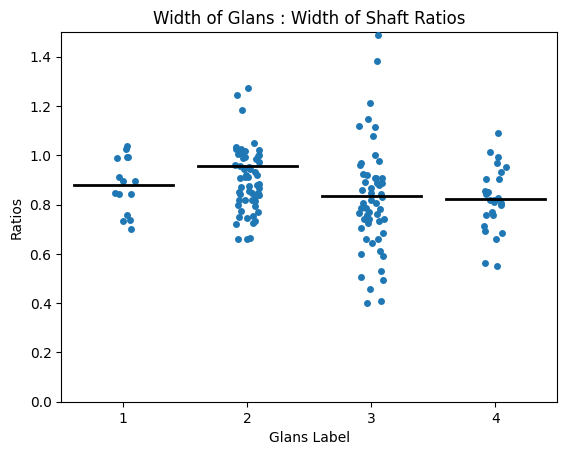

In [36]:
generate_stripplot(x='G-Label', y='Rect', df=g_dist_s_dist_overall_df, limits=[0, 1.5], xlabel='Glans Label', ylabel='Ratios', title='Width of Glans : Width of Shaft Ratios')

Width of glans : width of shaft ratio (CONDITIONED ON M SCORE < 3 i.e. distal hypospadius)

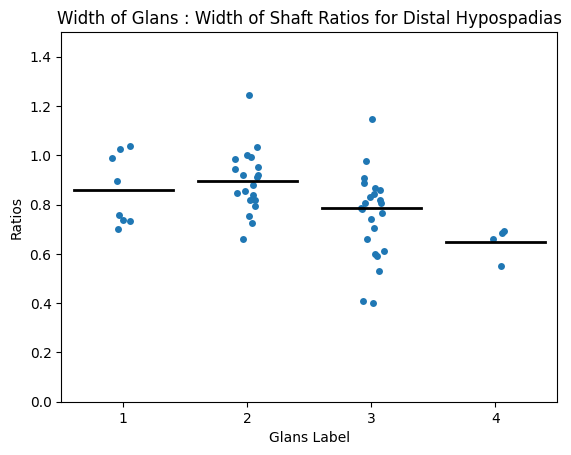

In [38]:
generate_stripplot(x='G-Label', y='Rect', df=g_dist_s_dist_overall_df[g_dist_s_dist_overall_df['M-Label'] < 3], limits=[0, 1.5], xlabel='Glans Label', ylabel='Ratios', title='Width of Glans : Width of Shaft Ratios for Distal Hypospadias')

Area of glans : width of shaft ratio

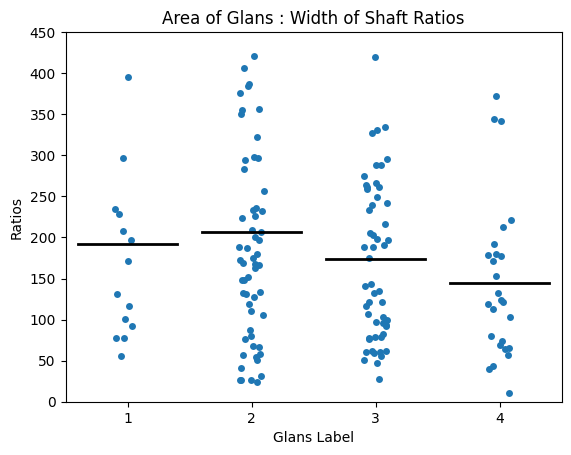

In [39]:
generate_stripplot(x='G-Label', y='Rect', df=g_area_s_dist_overall_df, limits=[0, 450], xlabel='Glans Label', ylabel='Ratios', title='Area of Glans : Width of Shaft Ratios')

Area of glans : width of shaft ratio (CONDITIONED ON M SCORE < 3 i.e. distal hypospadius)

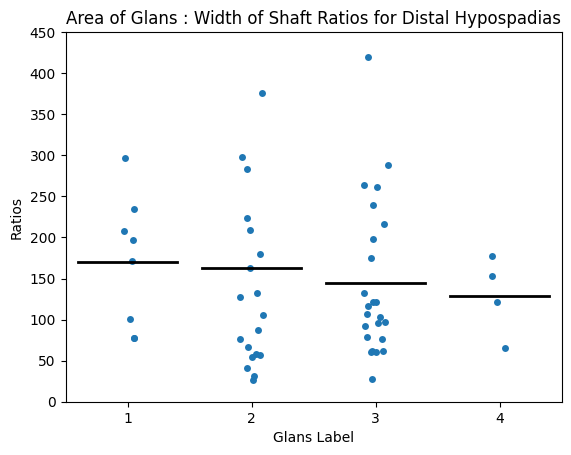

In [40]:
generate_stripplot(x='G-Label', y='Rect', df=g_area_s_dist_overall_df[g_area_s_dist_overall_df['M-Label'] < 3], limits=[0, 450], xlabel='Glans Label', ylabel='Ratios', title='Area of Glans : Width of Shaft Ratios for Distal Hypospadias')

Width of glans : area of shaft

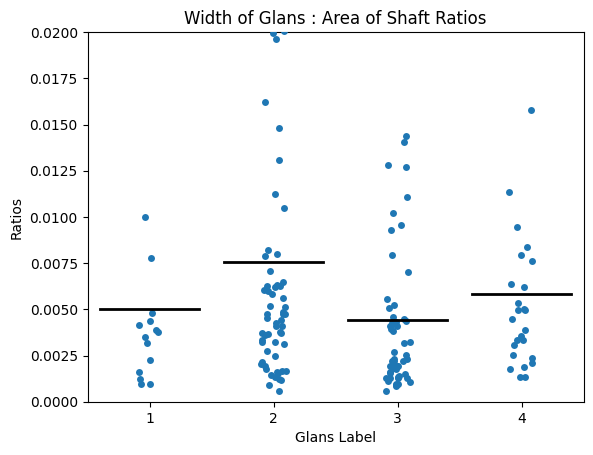

In [41]:
generate_stripplot(x='G-Label', y='Rect', df=g_dist_s_area_overall_df, limits=[0, 0.02], xlabel='Glans Label', ylabel='Ratios', title='Width of Glans : Area of Shaft Ratios')

Width of glans : area of shaft (CONDITIONED ON M SCORE < 3 i.e. distal hypospadius)

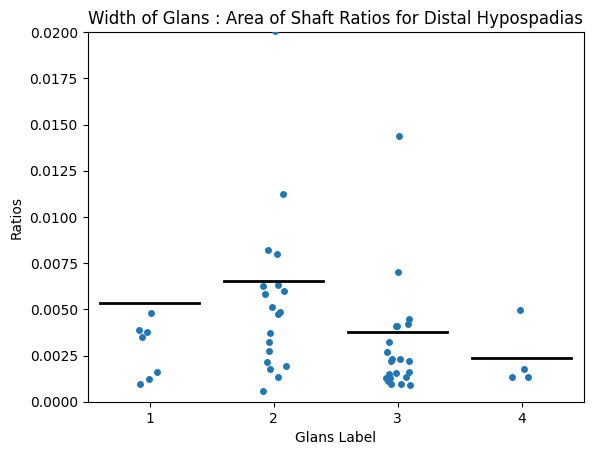

In [42]:
generate_stripplot(x='G-Label', y='Rect', df=g_dist_s_area_overall_df[g_dist_s_area_overall_df['M-Label'] < 3], limits=[0, 0.02], xlabel='Glans Label', ylabel='Ratios', title='Width of Glans : Area of Shaft Ratios for Distal Hypospadias')

Area of glans : area of shaft

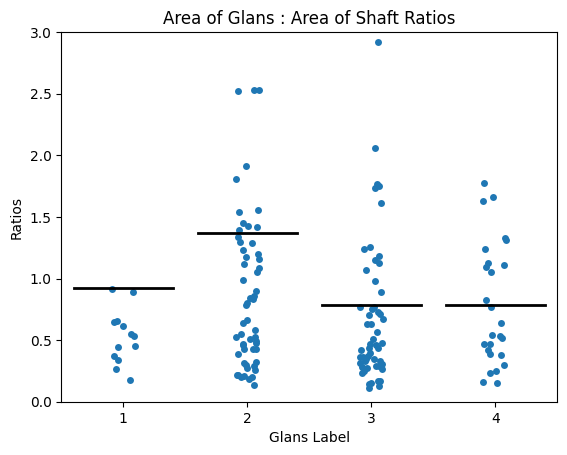

In [43]:
generate_stripplot(x='G-Label', y='Area', df=g_area_s_area_overall_df, limits=[0, 3], xlabel='Glans Label', ylabel='Ratios', title='Area of Glans : Area of Shaft Ratios')

Area of glans : area of shaft (CONDITIONED ON M SCORE < 3 i.e. distal hypospadius)

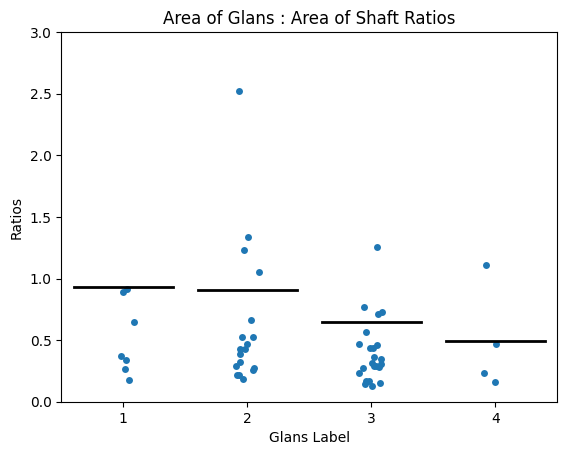

In [44]:
generate_stripplot(x='G-Label', y='Area', df=g_area_s_area_overall_df[g_area_s_area_overall_df['M-Label'] < 3], limits=[0, 3], xlabel='Glans Label', ylabel='Ratios', title='Area of Glans : Area of Shaft Ratios')

Width of UP : width of shaft

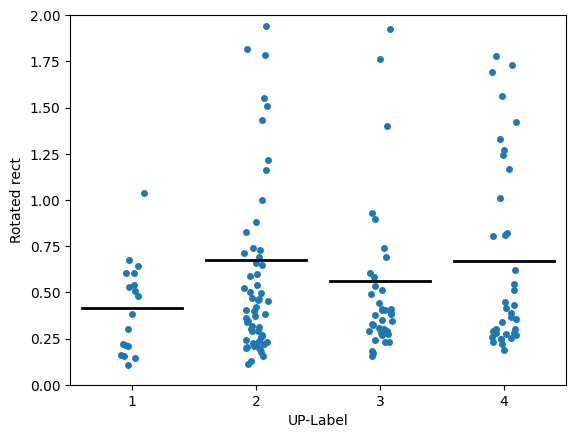

In [41]:
generate_stripplot(x='UP-Label', y='Rotated rect', df=u_dist_s_dist_overall_df, limits=[0, 2])

Width of UP : width of shaft (CONDITIONED ON M SCORE < 3 i.e. distal hypospadius)

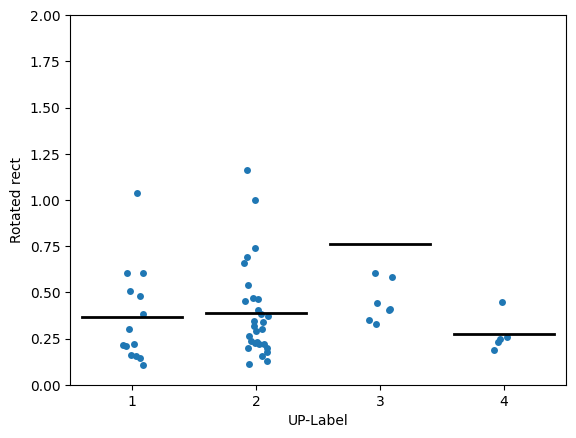

In [40]:
generate_stripplot(x='UP-Label', y='Rotated rect', df=u_dist_s_dist_overall_df[u_dist_s_dist_overall_df['M-Label'] < 3], limits=[0, 2])

Width of UP : width of glans

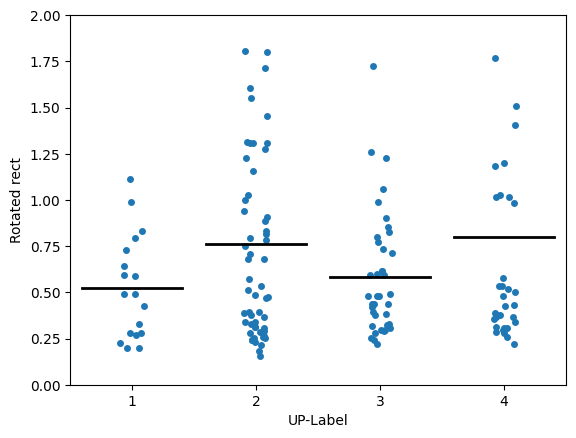

In [18]:
generate_stripplot(x='UP-Label', y='Rotated rect', df=u_dist_g_dist_overall_df, limits=[0, 2])

Width of UP : width of glans (CONDITIONED ON M SCORE < 3 i.e. distal hypospadius)

In [22]:
u_dist_g_dist_overall_df

Rect  Rotated rect  \
1.0 Hipospadia peniana distal com chordee e cap...  0.440678      0.434907   
2015-03-25 10.58.24                                 0.308824      0.318246   
2017-07-20, 07 40 08                                0.308235      0.304954   
2018-03-22 07.44.35                                 0.295566      0.423921   
2018-03-27 07.41.06                                 0.493888      0.709111   
...                                                      ...           ...   
bad plate                                           0.257778      0.221407   
c3                                                  0.338542      0.327737   
camara abril 2 de 2013 003                          0.538462      0.534483   
camara dic 10 de 2013 018                           0.440000      0.905165   
preop- severe chordee                               0.480480      0.478447   

                                                     Ellipse  Longest line  \
1.0 Hipospadia peniana distal com chordee e cap...  0.766117      0.818185   
2015-03-25 10.58.24                                 1.383049      1.270563   
2017-07-20, 07 40 08                                0.812876      0.820449   
2018-03-22 07.44.35                                 0.287980      0.299865   
2018-03-27 07.41.06                                 0.665790      0.622611   
...                                                      ...           ...   
bad plate                                           0.624570      0.586440   
c3                                                  0.359845      0.348152   
camara abril 2 de 2013 003                          0.634222      0.650577   
camara dic 10 de 2013 018                           0.924068      0.872235   
preop- severe chordee                               0.811465      0.727864   

                                                    G-Label  M-Label  UP-Label  
1.0 Hipospadia peniana distal com chordee e cap...        3        3         3  
2015-03-25 10.58.24                                       3        4         3  
2017-07-20, 07 40 08                                      1        1         2  
2018-03-22 07.44.35                                       2        2         1  
2018-03-27 07.41.06                                       3        2         2  
...                                                     ...      ...       ...  
bad plate                                                 2        2         4  
c3                                                        3        1         1  
camara abril 2 de 2013 003                                2        2         2  
camara dic 10 de 2013 018                                 2        2         2  
preop- severe chordee                                     2        4         3  

[154 rows x 7 columns]

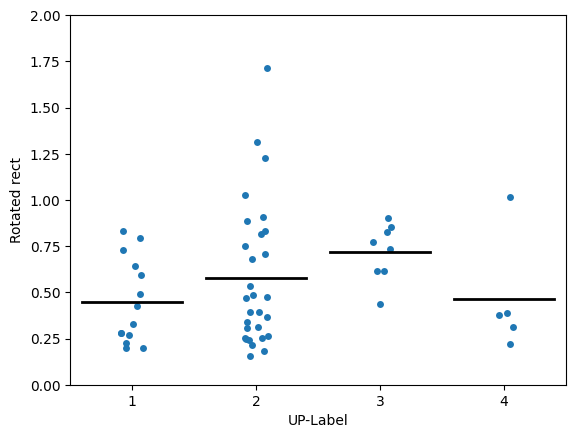

In [26]:
generate_stripplot(x='UP-Label', y='Rotated rect', df=u_dist_g_dist_overall_df[u_dist_g_dist_overall_df['M-Label'] < 3], limits=[0, 2])

#### Generating histograms for different ratios

Width of glans : width of shaft

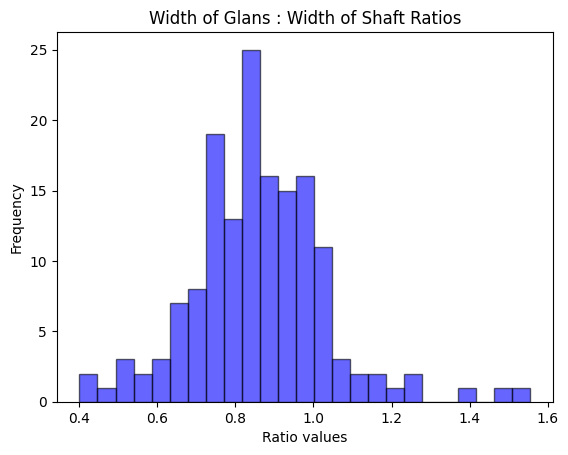

In [46]:
rect_g_dist_s_dist_ratio_values = g_dist_s_dist_overall_df['Rect'].to_list()
rect_g_dist_s_dist_ratio_values = [i for i in rect_g_dist_s_dist_ratio_values if i < 2]
fit_gaussian_curves(rect_g_dist_s_dist_ratio_values, num_bins=25, curve=False, density=False, title='Width of Glans : Width of Shaft Ratios')

Width of glans : width of shaft (CONDITIONED ON M SCORE < 3 i.e. distal hypospadias)

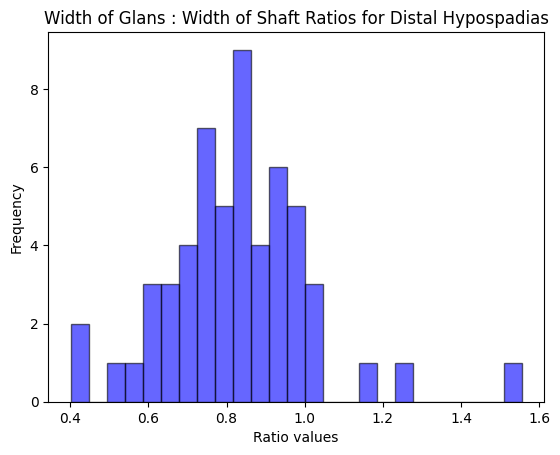

In [47]:
m_cond_rect_g_dist_s_dist_ratio_values = g_dist_s_dist_overall_df[g_dist_s_dist_overall_df['M-Label'] < 3]['Rect'].to_list()
m_cond_rect_g_dist_s_dist_ratio_values = [i for i in m_cond_rect_g_dist_s_dist_ratio_values if i < 2]
fit_gaussian_curves(m_cond_rect_g_dist_s_dist_ratio_values, num_bins=25, curve=False, density=False, title='Width of Glans : Width of Shaft Ratios for Distal Hypospadias')

Area of glans : width of shaft

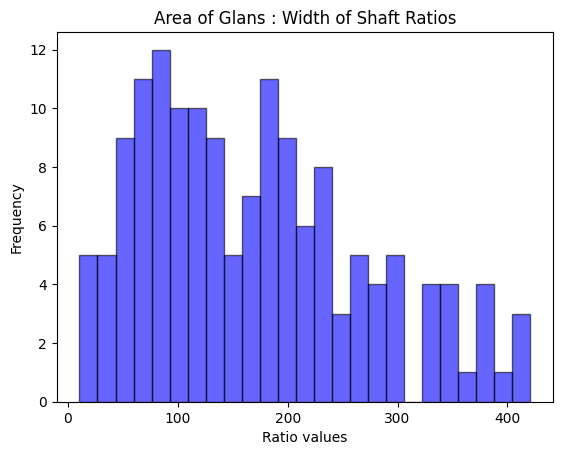

In [48]:
rect_g_area_s_dist_ratio_values = g_area_s_dist_overall_df['Rect'].to_list()
rect_g_area_s_dist_ratio_values = [i for i in rect_g_area_s_dist_ratio_values if i < 450]
fit_gaussian_curves(rect_g_area_s_dist_ratio_values, num_bins=25, curve=False, density=False, title='Area of Glans : Width of Shaft Ratios')

Width of glans : area of shaft

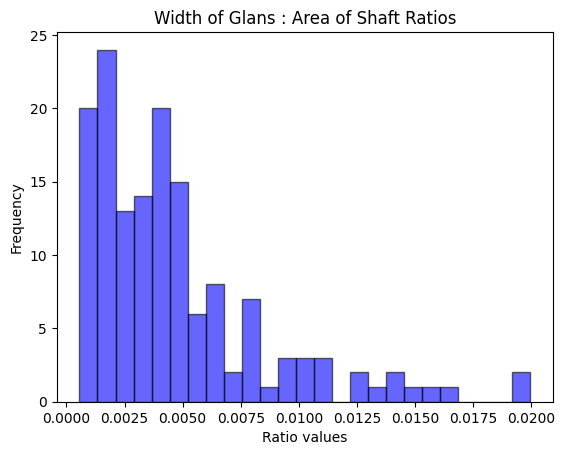

In [49]:
rect_g_dist_s_area_ratio_values = g_dist_s_area_overall_df['Rect'].to_list()
rect_g_dist_s_area_ratio_values = [i for i in rect_g_dist_s_area_ratio_values if i < 0.02]
fit_gaussian_curves(rect_g_dist_s_area_ratio_values, num_bins=25, curve=False, density=False, title='Width of Glans : Area of Shaft Ratios')

Area of glans : area of shaft

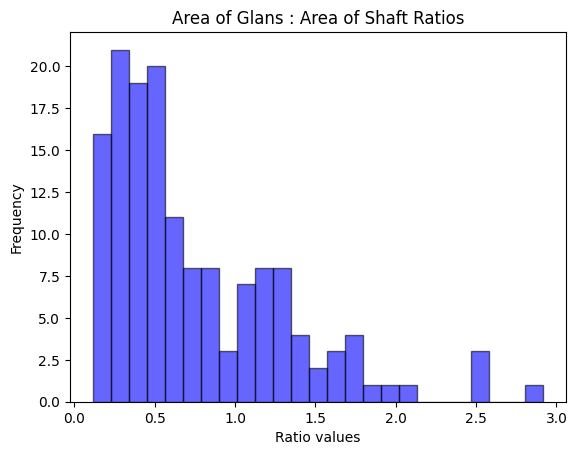

In [50]:
_g_area_s_area_ratio_values = g_area_s_area_overall_df['Area'].to_list()
_g_area_s_area_ratio_values = [i for i in _g_area_s_area_ratio_values if i < 3]
fit_gaussian_curves(_g_area_s_area_ratio_values, num_bins=25, curve=False, density=False, title='Area of Glans : Area of Shaft Ratios')

Width of UP : width of shaft

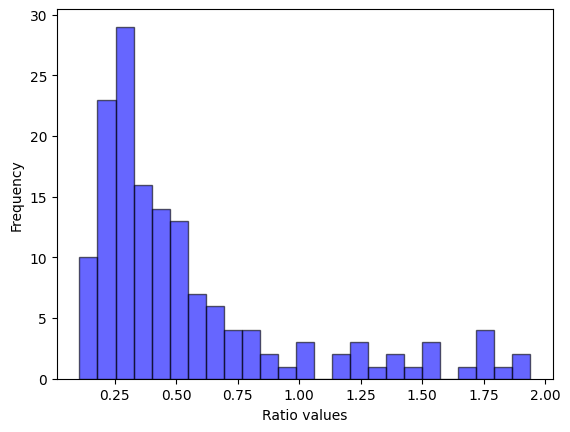

In [33]:
rect_u_dist_s_dist_ratio_values = u_dist_s_dist_overall_df['Rotated rect'].to_list()
rect_u_dist_s_dist_ratio_values = [i for i in rect_u_dist_s_dist_ratio_values if i < 2]
fit_gaussian_curves(rect_u_dist_s_dist_ratio_values, num_bins=25, curve=False, density=False)

In [ ]:
# Fit a normal distribution to 
# the data: 
# mean and standard deviation 
mu, std = scipy.stats.norm.fit(values)  

# Plot the histogram. 

plt.hist(values, bins=num_bins, density=True, alpha=0.6, color='b') 

# Plot the PDF. 
xmin, xmax = plt.xlim() 
x = np.linspace(xmin, xmax, 100) 
p = scipy.stats.norm.pdf(x, mu, std) 

plt.plot(x, p, 'k', linewidth=2) 
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std) 
plt.title(title) 

plt.show() 

In [176]:
np.array(rect_g_area_s_dist_ratio_values).reshape(-1, 1).shape

(151, 1)

### Playground

In [86]:
mask_path = "/home/pedke/dataset/datasets/15-October-23_split - no_special_chars/train/masks/DSC00094_glans.png"
img = cv2.imread(mask_path) 

# Convert to grayscale 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

#to separate the object from the background 
ret, thresh = cv2.threshold(gray, 127, 255, 0) 

# Dilating the mask
# https://stackoverflow.com/questions/68984409/cant-find-right-numbers-of-contours-count
kernel = np.ones((3, 3), dtype=np.uint8)
thresh = cv2.dilate(thresh, kernel, iterations=2)

# Find the contours of the object  
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 

# print(len(contours))
contours = np.vstack(contours[i] for i in range(len(contours)) if cv2.contourArea(contours[i]) > 1500)
# print(len(contours))

hull = cv2.convexHull(contours)
uni_hull = [hull]
cv2.drawContours(img,uni_hull,-1,(0,255,255),2)

# --------------------------------------
# min_values = get_extreme_value(hull, 'min', 0)
# max_values = get_extreme_value(hull, 'max', 0)

# for val in torch.concat([min_values, max_values]):
#     x, y = np.array(val)
#     print(np.array(val), x, y )
#     cv2.circle(img, (int(x), int(y)), radius=20, color=(0, 0, 255), thickness=-1)

# --------------------------------------
longest_dist, pnts = compute_longest_dist(hull)

for val in list(pnts):
    x, y = np.array(val)
    # print(np.array(val), x, y )
    cv2.circle(img, (int(x), int(y)), radius=10, color=(255, 0, 0), thickness=-1)
    
# --------------------------------------

# rotated rect
rect = cv2.minAreaRect(contours)
r_h, r_w = rect[1]
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(img,[box],0,(0,0,255),2)

# rect
x,y,w,h = cv2.boundingRect(contours)
cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

# ellipse
ellipse = cv2.fitEllipse(contours)
e_h, e_w = ellipse[1]
cv2.ellipse(img,ellipse,(255,255,0),2)


cv2.imwrite(f'trial.jpeg', img) 

dists = [w, r_w, e_w, longest_dist]

/tmp/ipykernel_1449746/18242402.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  contours = np.vstack(contours[i] for i in range(len(contours)) if cv2.contourArea(contours[i]) > 1500)
/tmp/ipykernel_1449746/18242402.py:49: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


In [87]:
r_h, r_w

(465.07745361328125, 266.0467529296875)

In [90]:
rect

((1660.5225830078125, 541.919189453125),
 (465.07745361328125, 266.0467529296875),
 1.555159568786621)

In [88]:
rect[1]

(465.07745361328125, 266.0467529296875)

In [89]:
w, h

(465, 271)